In [1]:
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("MNISTClassifier").getOrCreate()

24/05/15 15:29:44 WARN Utils: Your hostname, MacBook-Air-Anna.local resolves to a loopback address: 127.0.0.1; using 192.168.1.217 instead (on interface en0)
24/05/15 15:29:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/05/15 15:29:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/15 15:29:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df_training = (spark
               .read
               .options(header = True, inferSchema = True)
               .csv("data/MNIST/mnist_train.csv"))

In [4]:
print(df_training.count())

60000


In [5]:
feature_columns = df_training.columns[1:]

In [6]:
vectorizer = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [7]:
training = (vectorizer
            .transform(df_training)
            .select("label", "features")
            .toDF("label", "features")
            .cache())
training.show()

24/05/15 15:30:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+--------------------+
|label|            features|
+-----+--------------------+
|    5|(784,[152,153,154...|
|    0|(784,[127,128,129...|
|    4|(784,[160,161,162...|
|    1|(784,[158,159,160...|
|    9|(784,[208,209,210...|
|    2|(784,[155,156,157...|
|    1|(784,[124,125,126...|
|    3|(784,[151,152,153...|
|    1|(784,[152,153,154...|
|    4|(784,[134,135,161...|
|    3|(784,[123,124,125...|
|    5|(784,[216,217,218...|
|    3|(784,[143,144,145...|
|    6|(784,[72,73,74,99...|
|    1|(784,[151,152,153...|
|    7|(784,[211,212,213...|
|    2|(784,[151,152,153...|
|    8|(784,[159,160,161...|
|    6|(784,[100,101,102...|
|    9|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



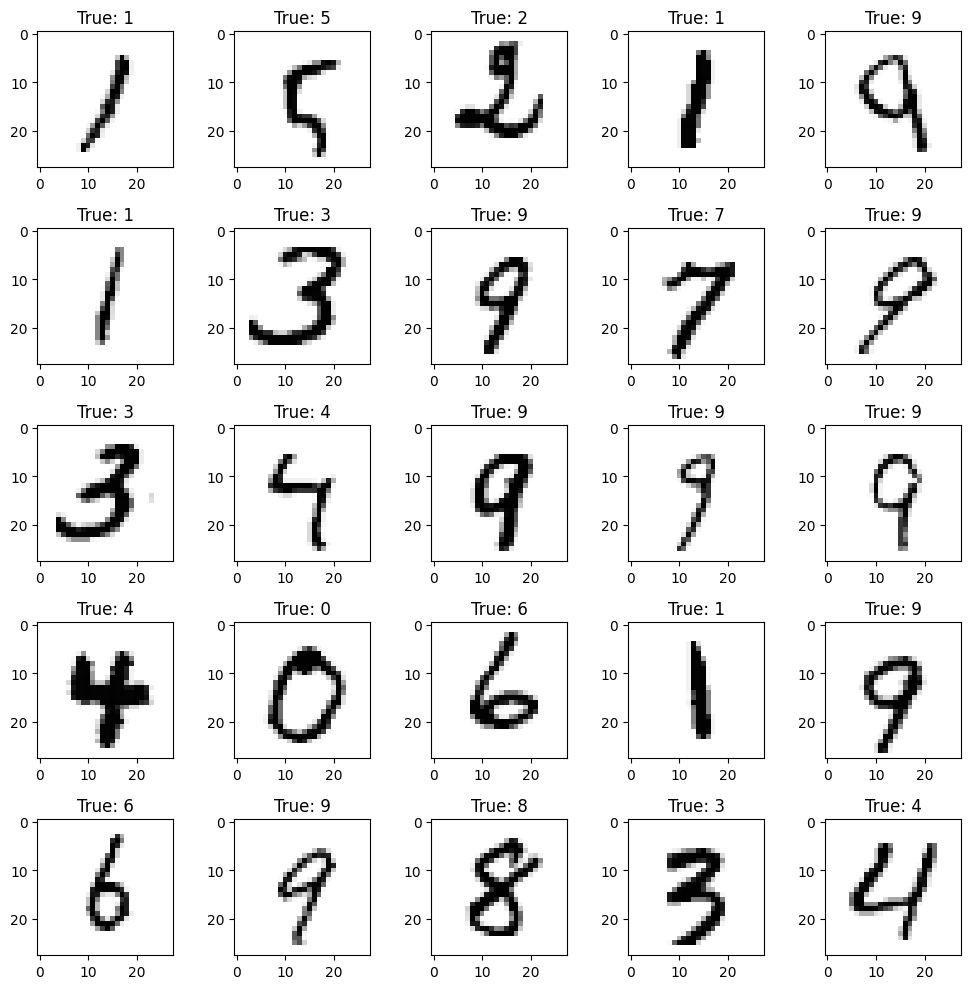

In [8]:
images = training.sample(False, 0.01, 1).take(25)
fig, _ = plt.subplots(5, 5, figsize = (10, 10))
for i, ax in enumerate(fig.axes):
    r = images[i]
    label = r.label
    features = r.features
    ax.imshow(features.toArray().reshape(28, 28), cmap = "Greys")
    ax.set_title("True: " + str(label))

plt.tight_layout()

In [9]:
df_testing = (spark
              .read
              .options(header = True, inferSchema = True)
              .csv("data/MNIST/mnist_test.csv"))
testing = (vectorizer
           .transform(df_testing)
           .select("label", "features")
           .toDF("label", "features")
           .cache())

In [10]:
testing.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    7|(784,[202,203,204...|
|    2|(784,[94,95,96,97...|
|    1|(784,[128,129,130...|
|    0|(784,[124,125,126...|
|    4|(784,[150,151,159...|
|    1|(784,[156,157,158...|
|    4|(784,[149,150,151...|
|    9|(784,[179,180,181...|
|    5|(784,[129,130,131...|
|    9|(784,[209,210,211...|
|    0|(784,[123,124,125...|
|    6|(784,[94,95,96,97...|
|    9|(784,[208,209,210...|
|    0|(784,[152,153,154...|
|    1|(784,[125,126,127...|
|    5|(784,[124,125,126...|
|    9|(784,[179,180,181...|
|    7|(784,[200,201,202...|
|    3|(784,[118,119,120...|
|    4|(784,[158,159,185...|
+-----+--------------------+
only showing top 20 rows



In [11]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

In [12]:
lr = LogisticRegression(featuresCol="features", 
                        labelCol="label", 
                        regParam=0.1, 
                        elasticNetParam=0.1, 
                        maxIter=10000)

In [13]:
lr_model = lr.fit(training)

24/05/15 15:31:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [15]:
from pyspark.sql.functions import *

In [16]:
test_pred = lr_model.transform(testing).withColumn("matched", expr("label == prediction"))
test_pred.show()

+-----+--------------------+--------------------+--------------------+----------+-------+
|label|            features|       rawPrediction|         probability|prediction|matched|
+-----+--------------------+--------------------+--------------------+----------+-------+
|    7|(784,[202,203,204...|[0.08067854951177...|[0.01163208437589...|       7.0|   true|
|    2|(784,[94,95,96,97...|[1.25426843060393...|[0.02467825163805...|       2.0|   true|
|    1|(784,[128,129,130...|[-1.2276907082524...|[0.00751217684479...|       1.0|   true|
|    0|(784,[124,125,126...|[3.71477828976670...|[0.85536461920364...|       0.0|   true|
|    4|(784,[150,151,159...|[-0.2039439205033...|[0.04549020935434...|       4.0|   true|
|    1|(784,[156,157,158...|[-1.8455470204559...|[0.00278424125822...|       1.0|   true|
|    4|(784,[149,150,151...|[-1.7872357669221...|[0.00965205014740...|       4.0|   true|
|    9|(784,[179,180,181...|[-2.3331650092131...|[0.00711897686391...|       9.0|   true|
|    5|(78

In [26]:
lr_model.save("lr_model")

24/05/14 11:45:43 WARN Executor: Issue communicating with driver in heartbeater 
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928

In [17]:
log_reg_model = LogisticRegressionModel.load("lr_model")

In [18]:
test_pred2 = log_reg_model.transform(testing)
test_pred2.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    7|(784,[202,203,204...|[0.08067854951177...|[0.01163208437589...|       7.0|
|    2|(784,[94,95,96,97...|[1.25426843060393...|[0.02467825163805...|       2.0|
|    1|(784,[128,129,130...|[-1.2276907082524...|[0.00751217684479...|       1.0|
|    0|(784,[124,125,126...|[3.71477828976670...|[0.85536461920364...|       0.0|
|    4|(784,[150,151,159...|[-0.2039439205033...|[0.04549020935434...|       4.0|
|    1|(784,[156,157,158...|[-1.8455470204559...|[0.00278424125822...|       1.0|
|    4|(784,[149,150,151...|[-1.7872357669221...|[0.00965205014740...|       4.0|
|    9|(784,[179,180,181...|[-2.3331650092131...|[0.00711897686391...|       9.0|
|    5|(784,[129,130,131...|[0.25086936192221...|[0.06160424879761...|       5.0|
|    9|(784,[209

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [20]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="accuracy")

In [21]:
print("Accuracy:", evaluator.evaluate(test_pred))

Accuracy: 0.8729


In [22]:
print("Accuracy:", evaluator.evaluate(test_pred2))

Accuracy: 0.8729
